# Image Detection - Car Damage Detector

to-add

### General Imports

In [146]:
import boto3
import sagemaker
import sys
import os
import re
import numpy as np
import subprocess
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import gzip
from io import BytesIO
import zipfile
import random
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### Constant Set-up

In [93]:

# NOTE: S3 bucket name must begin with "deeplens-" for DeepLens deployment
bucket_name='dataset-cars-damage'
prefix = ''
dataset_filename = 'car-damage-dataset.zip'
dataset_unpacked_dir = 'car-damage-dataset/'

### Environment Setup

In [76]:
def setup_env():
    
    role = get_execution_role()

    sess = sagemaker.Session()

    
    AWS_REGION = 'us-east-1'
    s3 = boto3.resource('s3')

    s3_bucket = s3.Bucket(bucket_name)

    if s3_bucket.creation_date == None:
    # create S3 bucket because it does not exist yet
        print('Creating S3 bucket {}.'.format(bucket))
        resp = s3.create_bucket(
            ACL='private',
            Bucket=bucket
        )
    else:
        print('Bucket already exists')
    return role, sess, AWS_REGION, s3,s3_bucket

role, sess,  AWS_REGION, s3, s3_bucket = setup_env()

Bucket already exists


### Download Data and Create Manifest

Note this step 



In [77]:
def create_dataset(bucket_name, s3_bucket):

    bucket = bucket_name

    s3 = boto3.client('s3', use_ssl=False)
    Key_unzip = dataset_unpacked_dir

    prefix = ""
    zipped_keys =  s3.list_objects_v2(Bucket=bucket, Prefix=prefix, Delimiter = "/")
    file_list = []
    for key in zipped_keys['Contents']:
        file_list.append(key['Key'])
        print(key)
    #This will give you list of files in the folder you mentioned as prefix
    s3_resource = boto3.resource('s3')
    #Now create zip object one by one, this below is for 1st file in file_list
    zip_obj = s3_resource.Object(bucket_name=bucket, key=file_list[0])
    print('Unpacking {}'.format(file_list[0]))
    print (zip_obj)
    buffer = BytesIO(zip_obj.get()["Body"].read())
    z = zipfile.ZipFile(buffer)
    for filename in z.namelist():
        file_info = z.getinfo(filename)
        s3_resource.meta.client.upload_fileobj(
            z.open(filename),
            Bucket=bucket,
            Key=Key_unzip + f'{filename}')
        
    
create_dataset(bucket_name, s3_bucket)

KeyError: 'Contents'

### Create the Dataset Manifest

The manifest file will comprise of a tab separated file, which contains an index (unique for all). the class, and the path to the file (s3 bucket location)



In [106]:
def create_dataset_manifest(bucket_name, s3, data_path):
    
    manifest_train = []
    manifest_val = []
    
    idx = 0
    conn = boto3.client('s3')  # again assumes boto.cfg setup, assume AWS S3
    
    for file in s3_bucket.objects.all():#(Bucket=bucket_name, Prefix=data_path)['Contents']:
        path = file.key
#         print(path)
        if ('.JPEG' in path) or ('.jpeg' in path):
            if 'training' in path:
                man = {}
                relative_path = path.replace('training/','')
#                 print(relative_path)
                if 'damage' in path:
                    data_class = 1.0
                else:
                    data_class = 0.0
                man = {'idx':idx, 'class': data_class, 'path':relative_path}
                manifest_train.append(man)
                
            if 'validation' in path:
                man = {}
                relative_path = path.replace('validation/','')
                if 'damage' in path:
                    data_class = 1.0
                else:
                    data_class = 0.0
                man = {'idx':idx, 'class': data_class, 'path':relative_path}
                manifest_val.append(man)
            idx += 1
    print('Training Dataset Size {}, Validation Size {}'.format(len(manifest_train), len(manifest_val)))
    
    
    #finally create the manifest output
    with open('train.lst', 'w') as file:
        for x in manifest_train:
            to_write = '{}\t{}\t{}\n'.format(x['idx'],x['class'],x['path'])
            file.write(to_write)
    
    with open('val.lst', 'w') as file:
        for x in manifest_val:
            to_write = '{}\t{}\t{}\n'.format(x['idx'],x['class'],x['path'])
            file.write(to_write)
            
    return manifest_train, manifest_val 
            
manifest_train, manifest_val  = create_dataset_manifest(s3_bucket, s3, '')   
    

Training Dataset Size 1046, Validation Size 261


In [107]:
def upload_metadata(s3_bucket, manifest_train, manifest_val):
    
    train_file_s3 = 'train_lst/train.lst'
    s3_bucket.upload_file('./train.lst', train_file_s3)
    val_file_s3 = 'val_lst/val.lst'
    s3_bucket.upload_file('./val.lst', val_file_s3)
    
    
upload_metadata(s3_bucket, manifest_train, manifest_val)


In [108]:
def setup_classifier():

    training_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
    print (training_image)
    return training_image

training_image = setup_classifier()

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest


In [109]:
def configure_estimator(bucket_name, sess, training_image):

    s3_output_location = 's3://{}/output'.format(bucket_name)
    ic = sagemaker.estimator.Estimator(training_image,
                                             role, 
                                             train_instance_count=3, 
                                             train_instance_type='ml.p2.xlarge',
                                             train_volume_size = 50,
                                             train_max_run = 360000,
                                             input_mode= 'File',
                                             output_path=s3_output_location,
                                             sagemaker_session=sess)
    return ic

ic = configure_estimator(bucket_name, sess, training_image)

In [113]:
def configure_hyperparams(ic):
    ic.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,150,250",
                             num_classes=2,
                             mini_batch_size=32,
                             epochs=10,
                             learning_rate=0.01,
                             top_k=1,
                             num_training_samples=1048,
                             precision_dtype='float32')
    
    return ic

ic = configure_hyperparams(ic)

In [114]:
def configure_data_channels(bucket_name):
    
    s3train = 's3://{}/training/'.format(bucket_name)
    s3validation = 's3://{}/validation/'.format(bucket_name)
    s3train_lst = 's3://{}/train_lst/'.format(bucket_name)
    s3validation_lst = 's3://{}/val_lst/'.format(bucket_name)
    print(s3train_lst)
    
    train_data = sagemaker.session.s3_input(s3train, distribution='FullyReplicated', 
                            content_type='application/x-image', s3_data_type='S3Prefix')
    validation_data = sagemaker.session.s3_input(s3validation, distribution='FullyReplicated', 
                                 content_type='application/x-image', s3_data_type='S3Prefix')
    train_data_lst = sagemaker.session.s3_input(s3train_lst, distribution='FullyReplicated', 
                            content_type='application/x-image', s3_data_type='S3Prefix')
    validation_data_lst = sagemaker.session.s3_input(s3validation_lst, distribution='FullyReplicated', 
                                 content_type='application/x-image', s3_data_type='S3Prefix')

    data_channels = {'train': train_data, 'validation': validation_data, 
                     'train_lst': train_data_lst, 'validation_lst': validation_data_lst}
    
    
    return data_channels

data_channels = configure_data_channels(bucket_name)

s3://dataset-cars-damage/train_lst/


## Train the model

In [115]:
ic.fit(inputs=data_channels, logs=True)

2020-01-29 05:07:18 Starting - Starting the training job...
2020-01-29 05:07:20 Starting - Launching requested ML instances......
2020-01-29 05:08:27 Starting - Preparing the instances for training............
2020-01-29 05:10:22 Downloading - Downloading input data...
2020-01-29 05:10:52 Training - Downloading the training image...
2020-01-29 05:11:38 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
Docker entrypoint called with argument(s): train
[01/29/2020 05:11:40 INFO 140571859007296] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weigh

[05:11:50] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x_ecl_Cuda_10.1.x.1888.0/AL2012/generic-flavor/src/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[05:11:50] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x_ecl_Cuda_10.1.x.1888.0/AL2012/generic-flavor/src/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)
[05:11:50] /opt/brazil-pkg-cache/packages/AIAlgorithmsMXNet/AIAlgorithmsMXNet-1.3.x_ecl_Cuda_10.1.x.1888.0/AL2012/generic-flavor/src/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (setting env variable MXNET_CUDNN_AUTOTUNE


2020-01-29 05:12:49 Uploading - Uploading generated training model
2020-01-29 05:12:49 Completed - Training job completed
Training seconds: 441
Billable seconds: 441


## Deploy the Endpoint

In [ ]:
ic_classifier = ic.deploy(initial_instance_count = 1,
                          instance_type = 'ml.m4.xlarge')

Using already existing model: image-classification-2020-01-29-05-07-18-484


---------------------

### Test the Classifier

('whole-val-0210.JPEG', 'images/whole-val-0210.JPEG')


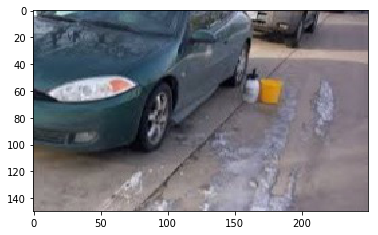

In [144]:
def display_test_img(bucket_name, test_manifest):
    
    root = 'validation/'
    test_count = len(test_manifest)
    random_annotation = test_manifest[random.randint(0,test_count-1)]
    s3_uri = random_annotation['path']
    
    s3_key = os.path.basename(s3_uri)
    local_path = 'images/' + s3_key
#     print(s3_key)
    s3.Bucket(bucket_name).download_file(
    root+s3_key, local_path)
    
    raw_img = mpimg.imread(local_path)
    plt.imshow(raw_img)
    return s3_key, local_path

s3_key = display_test_img(bucket_name, manifest_val)
print(s3_key)

Image Name damage-val-0012.JPEG
Result: label - Damage, probability - 0.9370570778846741


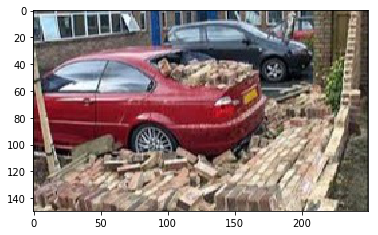

In [167]:
def test_image(bucket_name, test_manifest):
    
    s3_key, local_path = display_test_img(bucket_name, manifest_val)

    
    with open(local_path, 'rb') as f:
        payload = f.read()
        payload = bytearray(payload)
    
    ic_classifier.content_type = 'application/x-image'
    result = json.loads(ic_classifier.predict(payload))
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    object_categories = ['No Damage','Damage']
    print('Image Name {}'.format(s3_key))
    print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))
    
test_image(bucket_name, manifest_train)